<a href="https://colab.research.google.com/github/Mulberrycove/Hello-world/blob/main/Project_6016_UHI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:

ee.Authenticate()

#Initialize the Library
ee.Initialize(project='ee-rajpalsilwal')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

loc = '/content/drive/MyDrive/COMP6016:Project/'

Mounted at /content/drive


In [4]:
# Create a map centered around the AOI
Map = geemap.Map(center=[-31.95, 115.93], zoom=10)
Map.add_basemap('SATELLITE')


For the Subrub of Belmont, Perth

In [5]:
# Define the Area of Interest (AOI) And Scaling for AOI
aoi = ee.Geometry.Polygon(
    [[[115.8980475883435, -31.953507794644967],
      [115.93804468917358, -31.98787496739092],
      [115.94113459395874, -31.984380588412932],
      [115.97838511275756, -31.98743817729756],
      [115.98748316573608, -31.949138164617683],
      [115.95950236129272, -31.92408160792704],
      [115.96156229781616, -31.920147691041528],
      [115.95933069991577, -31.91927346443831],
      [115.95315089034546, -31.92189611932004],
      [115.94954600142944, -31.92408160792704],
      [115.94405283736694, -31.92233322119627],
      [115.94216456222046, -31.921604716915123],
      [115.94044794845092, -31.923790212446843],
      [115.93976130294311, -31.926121350435416],
      [115.9390746574353, -31.92961794661597],
      [115.93581309127319, -31.931220508760497],
      [115.9306632499646, -31.93224030649035],
      [115.92414011764038, -31.932968726514428],
      [115.91950526046264, -31.932823042971346],
      [115.91624369430053, -31.932968726514428],
      [115.91315378951538, -31.934425549247763],
      [115.91023554610717, -31.936465062288214],
      [115.9086905937146, -31.939961265076533],
      [115.91538538741577, -31.943457334871457],
      [115.91727366256225, -31.94418566600504],
      [115.91830363082397, -31.946079299935928],
      [115.91830363082397, -31.948555531577295],
      [115.91555704879272, -31.95103169648125],
      [115.91126551436889, -31.952925189316794],
      [115.90766062545288, -31.953799095923383],
      [115.90268244552124, -31.954818643123048]]])

# Function to apply scale factors
def apply_scale_factors(image):
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, overwrite=True).addBands(thermal_bands, overwrite=True)

# Cloud mask function
def mask_clouds(image):
    qa = image.select('QA_PIXEL')
    cloud_shadow_bit_mask = (1 << 3)
    clouds_bit_mask = (1 << 5)
    mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0).And(qa.bitwiseAnd(clouds_bit_mask).eq(0))
    return image.updateMask(mask)

In [37]:
### >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ###
### >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ###
### >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ###

# Load ET dataset (TERN/AET)
et_dataset = ee.ImageCollection('TERN/AET/CMRSET_LANDSAT_V2_2')

# Function to calculate NDVI, EVI, LST, UHI, and ET
def calculate_indices(image, aoi):


    # Calculate NDVI using the red and NIR bands (SR_B5 = NIR, SR_B4 = Red)
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

    # Calculate EVI using the formula
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        }).rename('EVI')

    # Fraction of Vegetation
    fv = ndvi.pow(2).rename('FV')

    # Emissivity calculation
    emissivity = fv.multiply(0.004).add(0.986).rename('EM')


    thermal = image.select('ST_B10').rename('thermal')

    # Calculate LST using the thermal band and emissivity
    lst = thermal.expression(
        '(tb / (1 + (0.00115 * (tb / 0.48359547432)) * log(em))) - 273.15', {
            'tb': thermal,
            'em': emissivity
        }).rename('LST')

    # Calculate mean and standard deviation of LST over the AOI
    lst_mean = lst.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi, scale=30).get('LST')
    lst_stddev = lst.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=aoi, scale=30).get('LST')

    # Calculate Urban Heat Island (UHI) index by normalizing the LST values
    uhi = lst.subtract(ee.Number(lst_mean)).divide(ee.Number(lst_stddev)).rename('UHI')

    # Calculate ET from TERN/AET dataset
    et = et_dataset.filterDate(image.date(), image.date().advance(1, 'month')).mean().select('ET').rename('ET')

    # Return vlues
    return {'ndvi': ndvi, 'evi': evi, 'lst': lst, 'uhi': uhi, 'et': et}

# calculate monthly mean for all indicies
def calculate_monthly_means_with_lags(start_year, end_year, aoi):
    features = []
    previous_ndvi_means = []

    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            if year == 2013 and month < 4:
                continue

            start_date = ee.Date.fromYMD(year, month, 1)
            end_date = start_date.advance(1, 'month')

            # Get the Landsat 8 Image Collection for the month
            image_collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                                .filterDate(start_date, end_date)
                                .filterBounds(aoi)
                                .map(apply_scale_factors)
                                .map(mask_clouds))

            # Calculate median image for the month
            median_image = image_collection.median()
            results = calculate_indices(median_image, aoi)

            #  mean NDVI, EVI, LST, UHI, and ET for the AOI
            ndvi_mean = results['ndvi'].reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi, scale=30).get('NDVI')
            evi_mean = results['evi'].reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi, scale=30).get('EVI')
            lst_mean = results['lst'].reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi, scale=30).get('LST')
            uhi_mean = results['uhi'].reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi, scale=30).get('UHI')
            et_mean = results['et'].reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi, scale=30).get('ET')

            #  NDVI values
            ndvi_3m_lag = previous_ndvi_means[-3] if len(previous_ndvi_means) >= 3 else None
            ndvi_6m_lag = previous_ndvi_means[-6] if len(previous_ndvi_means) >= 6 else None

            # Lag Calculations
            previous_ndvi_means.append(ndvi_mean)

            # Build features
            feature = ee.Feature(None, {
                'Year': year,
                'Month': month,
                'NDVI_Mean': ndvi_mean,
                'EVI_Mean': evi_mean,
                'LST_Mean': lst_mean,
                'UHI_Mean': uhi_mean,
                'ET_Mean': et_mean,
                'NDVI_3M_Lag': ndvi_3m_lag,
                'NDVI_6M_Lag': ndvi_6m_lag
            })

            features.append(feature)

    return ee.FeatureCollection(features)

# Calculate monthly mean data with lagged NDVI values from April 2013 to April 2023, including ET
monthly_data = calculate_monthly_means_with_lags(2013, 2023, aoi)


In [ ]:
# Export the results to Google Drive as a CSV file, specifying only the required properties
task = ee.batch.Export.table.toDrive(
    collection=monthly_data.select(['Year', 'Month', 'NDVI_Mean', 'EVI_Mean', 'LST_Mean', 'UHI_Mean', 'ET_Mean', 'NDVI_3M_Lag', 'NDVI_6M_Lag']),
    description='Monthly_Mean_with_Lags',
    fileFormat='CSV',
    folder='COMP6016:Project'
)

task.start()

In [44]:
csv_file_path = '/content/drive/My Drive/COMP6016:Project/Monthly_Mean.csv'
df = pd.read_csv(csv_file_path)
print(df.head(12))

    system:index  Year  Month  NDVI_Mean  EVI_Mean   ET_Mean   LST_Mean  \
0              0  2013      4   0.324550  0.184285  1.336162  24.738941   
1              1  2013      5   0.350187  0.202065  1.184791  20.180188   
2              2  2013      6   0.346241  0.207078  0.816923  20.098238   
3              3  2013      7   0.350465  0.204419  0.954837  19.525454   
4              4  2013      8   0.349976  0.205551  1.262782  22.821536   
5              5  2013      9   0.362784  0.196528  1.870516  23.660793   
6              6  2013     10   0.306556  0.200547  2.237851  32.665252   
7              7  2013     11   0.276469  0.187700  2.711761  40.567292   
8              8  2013     12   0.263706  0.186462  3.104590  40.913151   
9              9  2014      1   0.257996  0.177995  3.087712  44.848163   
10            10  2014      2   0.253972  0.170409  2.822208  41.317747   
11            11  2014      3   0.254266  0.168511  2.002961  35.760419   

        UHI_Mean     UTF

In [9]:
print(df.info())

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  129 non-null    int64  
 1   Year          129 non-null    int64  
 2   Month         129 non-null    int64  
 3   NDVI_Mean     129 non-null    float64
 4   EVI_Mean      129 non-null    float64
 5   ET (mm/day)   129 non-null    float64
 6   LST_Mean      129 non-null    float64
 7   UHI_Mean      129 non-null    float64
 8   UTFVI         129 non-null    float64
 9   NDVI_3M_Lag   126 non-null    float64
 10  NDVI_6M_Lag   123 non-null    float64
dtypes: float64(8), int64(3)
memory usage: 11.2 KB
None


,system:index,Year,Month,NDVI_Mean,EVI_Mean,ET (mm/day),LST_Mean,UHI_Mean,UTFVI,NDVI_3M_Lag,NDVI_6M_Lag
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,1.290000e+02,129.000000,126.000000,123.000000
mean,64.000000,2018.116279,6.604651,0.298794,0.183854,1.813290,31.667735,1.379218e-14,-0.009735,0.299803,0.298481
std,37.383151,3.116558,3.433335,0.041248,0.016094,0.664162,9.823311,9.715528e-14,0.011987,0.041128,0.040236
min,0.000000,2013.000000,1.000000,0.244637,0.119962,0.816923,16.292869,-3.036345e-13,-0.083414,0.245126,0.245126
25%,32.000000,2015.000000,4.000000,0.260604,0.172040,1.200502,22.750975,-5.292174e-14,-0.010110,0.263054,0.261759
50%,64.000000,2018.000000,7.000000,0.291700,0.183378,1.786965,31.456519,1.629969e-14,-0.006076,0.293482,0.291700
75%,96.000000,2021.000000,10.000000,0.331222,0.196528,2.518358,41.317747,6.717430e-14,-0.004830,0.331394,0.331337
max,128.000000,2023.000000,12.000000,0.414982,0.240059,3.104590,47.965854,3.316534e-13,0.023533,0.414982,0.414982


In [10]:
correlation = df['NDVI_Mean'].corr(df['LST_Mean'])
print("Correlation between NDVI and LST:", correlation)


Correlation between NDVI and LST: -0.8828534912816071


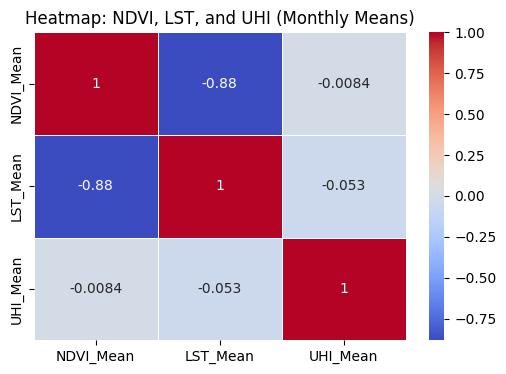

In [46]:
#  NDVI_Mean, LST_Mean, and UHI_Mean
df_filtered = df[['NDVI_Mean', 'LST_Mean', 'UHI_Mean']]

# the correlation matrix
correlation_matrix_filtered = df_filtered.corr()

# heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix_filtered, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap: NDVI, LST, and UHI (Monthly Means)")
plt.show()

The -0.88 correlation of coefficient reflects the strong negative realtionship between two variables. Implying support to the idea of vegetation helps in lowering the LST over the AOI, other factors might be into play for NDVI and UHI relation.

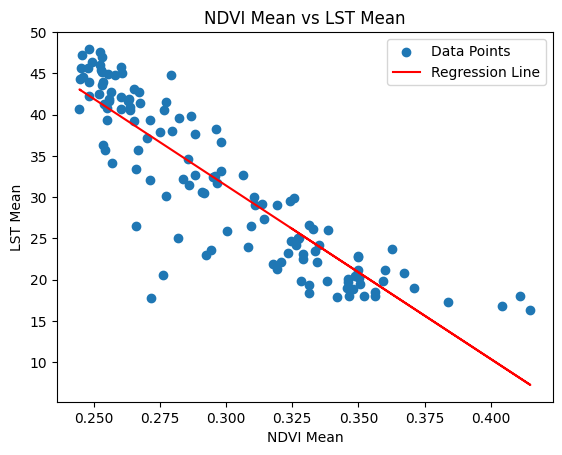

R-squared: 0.7794302870681221
Correlation Coefficient: -0.8828534912816071


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prepare the data for linear regression
X = df['NDVI_Mean'].values.reshape(-1, 1)  # as the independent variable (X)
y = df['LST_Mean'].values # LST as the dependent (y)

#  fit the linear regression
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# r2
r_squared = r2_score(y, y_pred)

# Correlation Coefficient
correlation_coefficient = np.corrcoef(df['NDVI_Mean'], df['LST_Mean'])[0, 1]

# Plot NDVI vs LST
plt.scatter(df['NDVI_Mean'], df['LST_Mean'], label='Data Points')
plt.plot(df['NDVI_Mean'], y_pred, color='red', label='Regression Line')
plt.title('NDVI Mean vs LST Mean')
plt.xlabel('NDVI Mean')
plt.ylabel('LST Mean')
plt.legend()
plt.show()

# Display R-squared and correlation coefficient
print(f'R-squared: {r_squared}')
print(f'Correlation Coefficient: {correlation_coefficient}')


Negative corelation is shown as NDVI increases the LST tends to decrease. R2 of 0.77 suggests approx 78% of the variance in LST can be explained by NDVI.

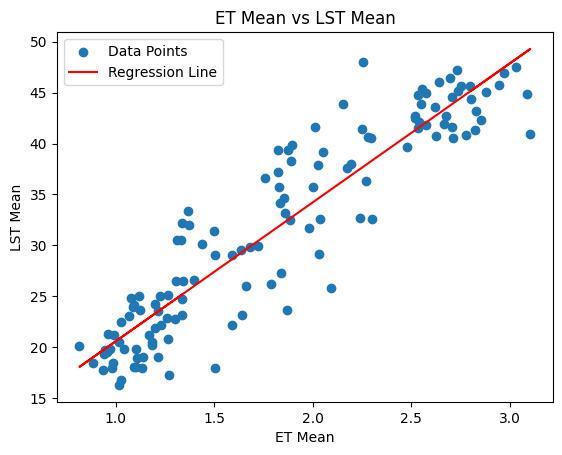

R-squared: 0.8520401671495427
Correlation Coefficient: 0.9230602185933173


In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for linear regression with ET as the independent variable and LST as the dependent variable
X = df['ET_Mean'].values.reshape(-1, 1)  # ET as the independent variable (X)
y = df['LST_Mean'].values  # LST as the dependent variable (y)

# Fit the linear regression
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Calculate R-squared
r_squared = r2_score(y, y_pred)

# Calculate Correlation Coefficient
correlation_coefficient = np.corrcoef(df['ET_Mean'], df['LST_Mean'])[0, 1]

# Plot ET vs LST
plt.scatter(df['ET_Mean'], df['LST_Mean'], label='Data Points')
plt.plot(df['ET_Mean'], y_pred, color='red', label='Regression Line')
plt.title('ET Mean vs LST Mean')
plt.xlabel('ET Mean')
plt.ylabel('LST Mean')
plt.legend()
plt.show()

# Display R-squared and correlation coefficient
print(f'R-squared: {r_squared}')
print(f'Correlation Coefficient: {correlation_coefficient}')


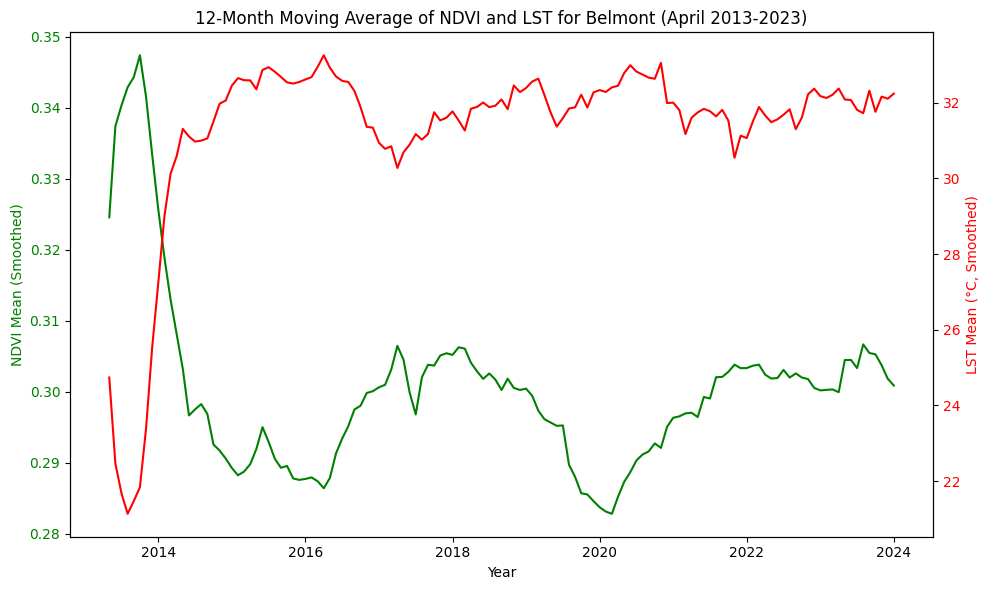

In [13]:
# Filter data to start from April 2013
df_filtered = df[(df['Year'] > 2013) | ((df['Year'] == 2013) & (df['Month'] >= 4))]

# Recalculate the rolling mean for the filtered data
df_filtered['NDVI_Smooth'] = df_filtered['NDVI_Mean'].rolling(window=12, min_periods=1).mean()
df_filtered['LST_Smooth'] = df_filtered['LST_Mean'].rolling(window=12, min_periods=1).mean()

# Plot the adjusted data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot NDVI
ax1.plot(df_filtered['Year'] + df_filtered['Month'] / 12, df_filtered['NDVI_Smooth'], label='NDVI (Smoothed)', color='green')
ax1.set_xlabel('Year')
ax1.set_ylabel('NDVI Mean (Smoothed)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Plot LST
ax2 = ax1.twinx()
ax2.plot(df_filtered['Year'] + df_filtered['Month'] / 12, df_filtered['LST_Smooth'], label='LST (Smoothed)', color='red')
ax2.set_ylabel('LST Mean (°C, Smoothed)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('12-Month Moving Average of NDVI and LST for Belmont (April 2013-2023)')
fig.tight_layout()
plt.show()


Assessing the Average Land Surface Temperature in High NVDI and Low NVDI.

In [14]:
#  NDVI threshold
low_ndvi_threshold = 0.27 # (Low NDVI = 0.26754, 25th %)
high_ndvi_threshold = 0.33  # (High NVDI = 0.340041, 75 %)

results = []

# Group data by year
for year, group in df.groupby('Year'):
    # Filter high and low NDVI based on fixed thresholds
    high_ndvi_df = group[group['NDVI_Mean'] >= high_ndvi_threshold]
    low_ndvi_df = group[group['NDVI_Mean'] <= low_ndvi_threshold]

    # Calculate the mean LST for high and low NDVI
    mean_lst_high_ndvi = high_ndvi_df['LST_Mean'].mean() if not high_ndvi_df.empty else None
    mean_lst_low_ndvi = low_ndvi_df['LST_Mean'].mean() if not low_ndvi_df.empty else None

    # Compute LST difference if both values are available
    lst_difference = mean_lst_high_ndvi - mean_lst_low_ndvi if mean_lst_high_ndvi is not None and mean_lst_low_ndvi is not None else None

    # Append results
    results.append({
        'Year': year,
        'Mean_LST_High_NDVI': mean_lst_high_ndvi,
        'Mean_LST_Low_NDVI': mean_lst_low_ndvi,
        'LST_Difference': lst_difference
    })

# Create DataFrame from results
results_df = pd.DataFrame(results)
print(results_df)


    Year  Mean_LST_High_NDVI  Mean_LST_Low_NDVI  LST_Difference
0   2013           21.257242          40.913151      -19.655909
1   2014           20.608731          40.415830      -19.807099
2   2015           18.878067          42.425267      -23.547200
3   2016           19.054750          42.950449      -23.895699
4   2017           18.542982          44.112632      -25.569650
5   2018           21.839115          42.898216      -21.059101
6   2019           19.858662          39.906807      -20.048144
7   2020           20.524452          44.774272      -24.249820
8   2021           21.853240          41.209565      -19.356325
9   2022           19.381013          43.126969      -23.745956
10  2023           20.892337          42.616293      -21.723956


High NDVI areas show significantly lower temperatures compared to low NDVI areas, highlighting the importance of vegetation in mitigating the Urban Heat Island effect. The consistent negative difference strongly supports the idea that vegetation has a cooling effect on surface temperatures.

In [50]:
# Find ET
# Define NDVI thresholds
low_ndvi_threshold = 0.27  # (Low NDVI = 0.26754, 25th percentile)
high_ndvi_threshold = 0.33  # (High NDVI = 0.340041, 75th percentile)

et_results = []

# Group data by year
for year, group in df.groupby('Year'):
    # Filter high and low NDVI based on fixed thresholds
    high_ndvi_df = group[group['NDVI_Mean'] >= high_ndvi_threshold]
    low_ndvi_df = group[group['NDVI_Mean'] <= low_ndvi_threshold]

    # Calculate the mean ET for high and low NDVI
    mean_et_high_ndvi = high_ndvi_df['ET_Mean'].mean() if not high_ndvi_df.empty else None
    mean_et_low_ndvi = low_ndvi_df['ET_Mean'].mean() if not low_ndvi_df.empty else None

    # Compute ET difference if both values are available
    et_difference = mean_et_high_ndvi - mean_et_low_ndvi if mean_et_high_ndvi is not None and mean_et_low_ndvi is not None else None

    # Append results
    et_results.append({
        'Year': year,
        'Mean_ET_High_NDVI': mean_et_high_ndvi,
        'Mean_ET_Low_NDVI': mean_et_low_ndvi,
        'ET_Difference': et_difference
    })

# Create DataFrame from results
et_results_df = pd.DataFrame(et_results)
print(et_results_df)


    Year  Mean_ET_High_NDVI  Mean_ET_Low_NDVI  ET_Difference
0   2013           1.217970          3.104590      -1.886620
1   2014           1.080763          2.341329      -1.260566
2   2015           0.913900          2.415268      -1.501368
3   2016           1.117048          2.382652      -1.265604
4   2017           1.141337          2.594196      -1.452859
5   2018           1.329874          2.566286      -1.236412
6   2019           1.104748          2.297855      -1.193107
7   2020           1.119426          2.600734      -1.481309
8   2021           1.301459          2.668330      -1.366871
9   2022           1.212436          2.684217      -1.471781
10  2023           1.209496          2.623958      -1.414462


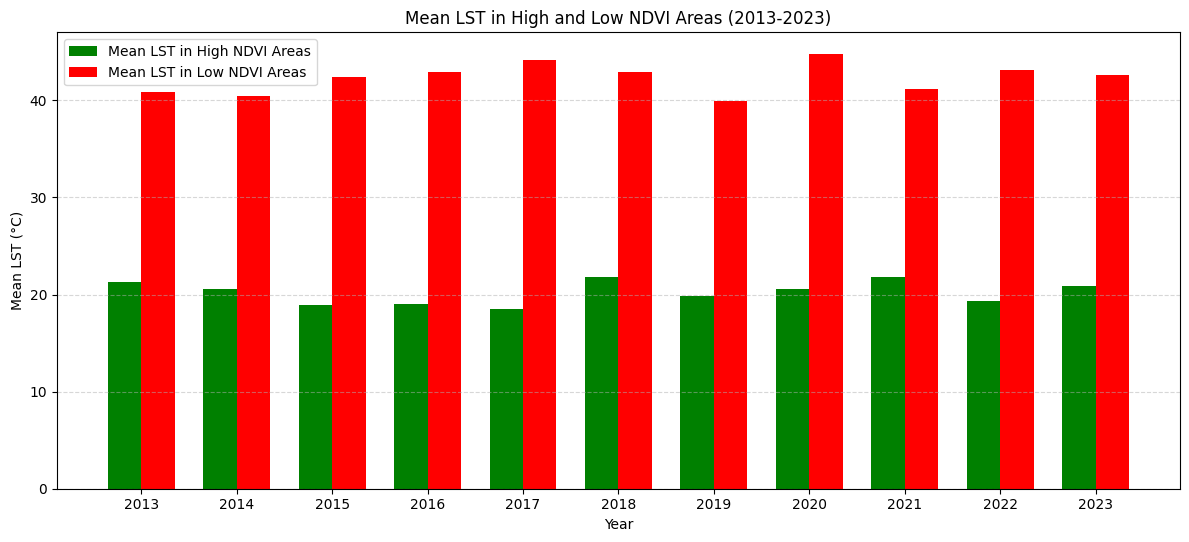

In [15]:
# Bar-graph for LST in high NDVI and Low NDVI areas >>>>

# Data from LST in high NDVI AND Low NDVI
years = results_df['Year']
high_ndvi_lst = results_df['Mean_LST_High_NDVI']
low_ndvi_lst = results_df['Mean_LST_Low_NDVI']

# Width of  the bar chart
bar_width = 0.35

# x-AXIS posityion
index = np.arange(len(years))

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Bar for High NDVI and Low NDVI
bars1 = ax.bar(index - bar_width/2, high_ndvi_lst, bar_width, label='Mean LST in High NDVI Areas', color='green')
bars2 = ax.bar(index + bar_width/2, low_ndvi_lst, bar_width, label='Mean LST in Low NDVI Areas', color='red')

# Labels
ax.set_xlabel('Year')
ax.set_ylabel('Mean LST (°C)')
ax.set_title('Mean LST in High and Low NDVI Areas (2013-2023)')
ax.set_xticks(index)
ax.set_xticklabels(years)
ax.legend()

# \.layout
ax.grid(True, linestyle='--', alpha=0.5, axis='y')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


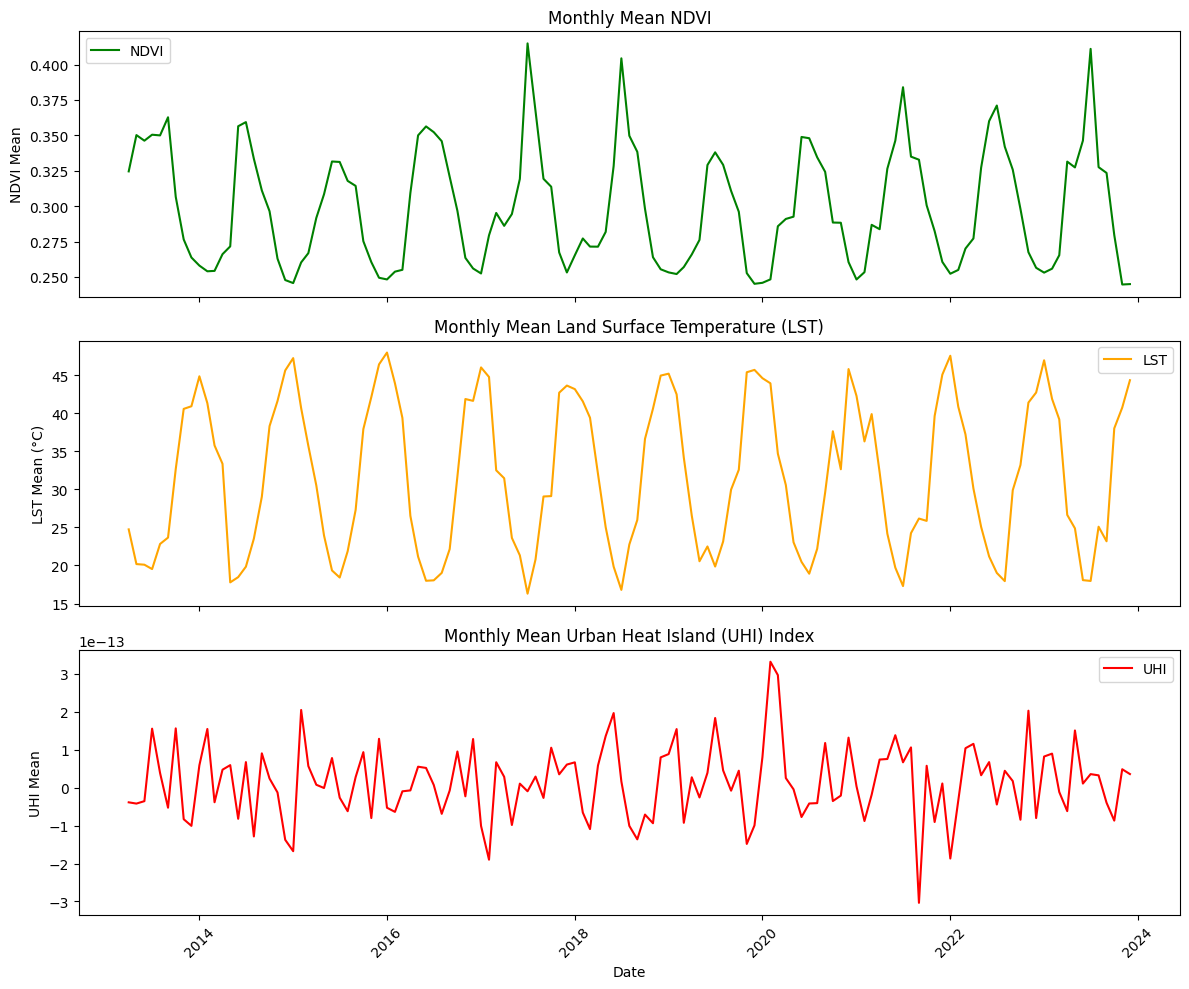

In [16]:
# Year and month columns to a datetime format for easier plotting
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')

# Set Date as the index
df.set_index('Date', inplace=True)

# Ploting teh values as time series
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# NDVI
ax[0].plot(df.index, df['NDVI_Mean'], color='green', label='NDVI')
ax[0].set_ylabel('NDVI Mean')
ax[0].set_title('Monthly Mean NDVI')
ax[0].legend()

# LST
ax[1].plot(df.index, df['LST_Mean'], color='orange', label='LST')
ax[1].set_ylabel('LST Mean (°C)')
ax[1].set_title('Monthly Mean Land Surface Temperature (LST)')
ax[1].legend()

# UHI
ax[2].plot(df.index, df['UHI_Mean'], color='red', label='UHI')
ax[2].set_ylabel('UHI Mean')
ax[2].set_title('Monthly Mean Urban Heat Island (UHI) Index')
ax[2].legend()

# Adjusted x-axis
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Inverse Relationship Between NDVI and LST: When NDVI is high (winter), LST is low, which suggests that increased vegetation cover may contribute to cooler land surface temperatures. Conversely, when NDVI is low (summer), LST peaks, indicating reduced cooling effects from vegetation.
UHI trend appears more erratic, with peaks and troughs occurring in various seasons. This irregular pattern may suggest that UHI is influenced by factors beyond just seasonal changes, such as urbanization, building density, or occasional climate anomalies.

Now assessing the relationship between NVDI and UHI.

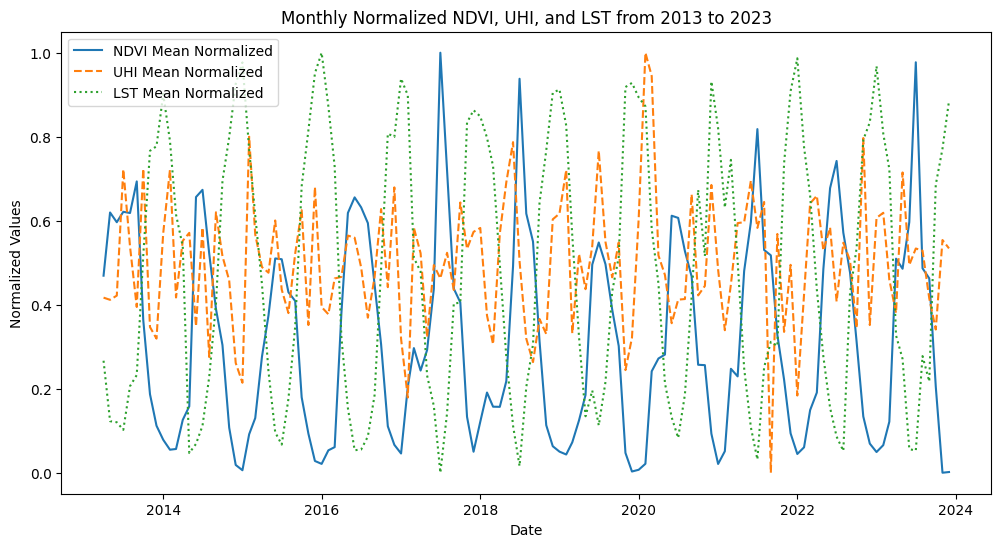

In [17]:
# Group by Year and Month to calculate monthly mean for NDVI, UHI, and LST
monthly_mean_df = df.groupby(['Year', 'Month'])[['NDVI_Mean', 'UHI_Mean', 'LST_Mean']].mean().reset_index()

# Normalize NDVI_Mean, UHI_Mean, and LST_Mean columns
monthly_mean_df['NDVI_Mean_Normalized'] = (monthly_mean_df['NDVI_Mean'] - monthly_mean_df['NDVI_Mean'].min()) / (monthly_mean_df['NDVI_Mean'].max() - monthly_mean_df['NDVI_Mean'].min())
monthly_mean_df['UHI_Mean_Normalized'] = (monthly_mean_df['UHI_Mean'] - monthly_mean_df['UHI_Mean'].min()) / (monthly_mean_df['UHI_Mean'].max() - monthly_mean_df['UHI_Mean'].min())
monthly_mean_df['LST_Mean_Normalized'] = (monthly_mean_df['LST_Mean'] - monthly_mean_df['LST_Mean'].min()) / (monthly_mean_df['LST_Mean'].max() - monthly_mean_df['LST_Mean'].min())

# Remove the original NDVI_Mean, UHI_Mean, and LST_Mean columns to keep only normalized data
monthly_mean_df = monthly_mean_df[['Year', 'Month', 'NDVI_Mean_Normalized', 'UHI_Mean_Normalized', 'LST_Mean_Normalized']]

# Create a 'Date' column to plot time series data
monthly_mean_df['Date'] = pd.to_datetime(monthly_mean_df[['Year', 'Month']].assign(Day=1))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_mean_df['Date'], monthly_mean_df['NDVI_Mean_Normalized'], label='NDVI Mean Normalized')
plt.plot(monthly_mean_df['Date'], monthly_mean_df['UHI_Mean_Normalized'], label='UHI Mean Normalized', linestyle='--')
plt.plot(monthly_mean_df['Date'], monthly_mean_df['LST_Mean_Normalized'], label='LST Mean Normalized', linestyle=':')

plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.title('Monthly Normalized NDVI, UHI, and LST from 2013 to 2023')
plt.legend()
plt.show()


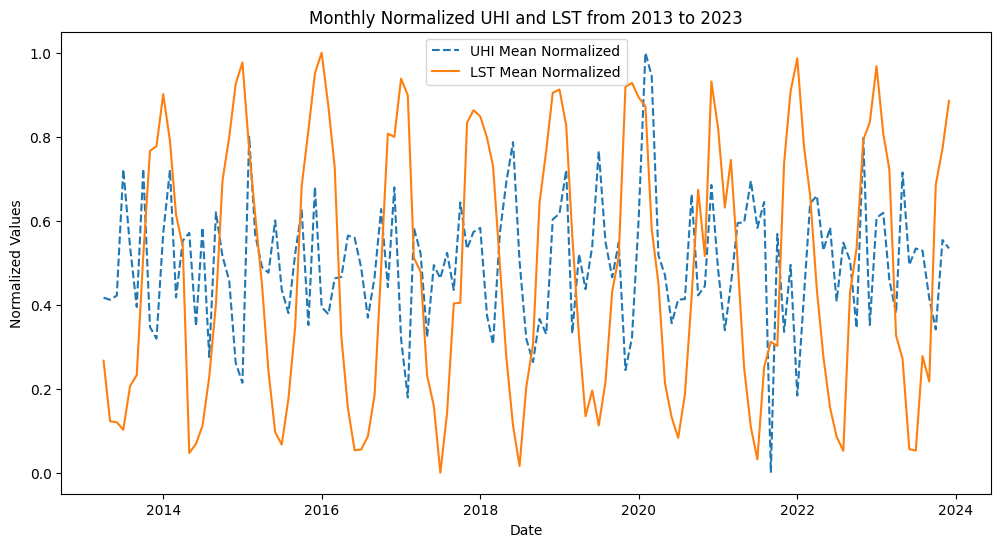

In [18]:
# Group by Year and Month to calculate monthly mean for LST and UHI
monthly_mean_df = df.groupby(['Year', 'Month'])[['UHI_Mean', 'LST_Mean']].mean().reset_index()

# Normalize UHI_Mean and LST_Mean columns
monthly_mean_df['UHI_Mean_Normalized'] = (monthly_mean_df['UHI_Mean'] - monthly_mean_df['UHI_Mean'].min()) / (monthly_mean_df['UHI_Mean'].max() - monthly_mean_df['UHI_Mean'].min())
monthly_mean_df['LST_Mean_Normalized'] = (monthly_mean_df['LST_Mean'] - monthly_mean_df['LST_Mean'].min()) / (monthly_mean_df['LST_Mean'].max() - monthly_mean_df['LST_Mean'].min())

# Remove the original UHI_Mean and LST_Mean columns to keep only normalized data
monthly_mean_df = monthly_mean_df[['Year', 'Month', 'UHI_Mean_Normalized', 'LST_Mean_Normalized']]

# Create a 'Date' column to plot time series data
monthly_mean_df['Date'] = pd.to_datetime(monthly_mean_df[['Year', 'Month']].assign(Day=1))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_mean_df['Date'], monthly_mean_df['UHI_Mean_Normalized'], label='UHI Mean Normalized', linestyle='--')
plt.plot(monthly_mean_df['Date'], monthly_mean_df['LST_Mean_Normalized'], label='LST Mean Normalized')

plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.title('Monthly Normalized UHI and LST from 2013 to 2023')
plt.legend()
plt.show()


In [19]:
# Exploring whether the vegetation represneted by NDVI which peaks at winter has an impact on precedding months,
# as it may have cooling effect on the UHI during summer time.

import statsmodels.api as sm

df['NDVI_3M_Lag'] = df['NDVI_Mean'].shift(3)
df['NDVI_6M_Lag'] = df['NDVI_Mean'].shift(6)

# Filter for summer months only (December to February in Australia)
summer_df = df[df['Month'].isin([12, 1, 2])].dropna()

# dependent variable (summer UHI) and independent variables (lagged NDVI values)
Y = summer_df['LST_Mean']
X = summer_df[['NDVI_3M_Lag', 'NDVI_6M_Lag']]

# intercept
X = sm.add_constant(X)

# regression model
model = sm.OLS(Y, X).fit()

# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               LST_Mean   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.5684
Date:                Fri, 15 Nov 2024   Prob (F-statistic):              0.573
Time:                        12:00:16   Log-Likelihood:                -71.631
No. Observations:                  31   AIC:                             149.3
Df Residuals:                      28   BIC:                             153.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          34.9371      8.600      4.062      

 It suggest that there is no clear delayed effect of winter NDVI on summer UHI, as the lagged NDVI values (both 3-month and 6-month) do not appear to correlate significantly with summer UHI in this dataset. This may imply that the cooling effects of vegetation are more immediate or seasonal, rather than having a delayed impact on UHI in the following summer.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Selected Lag Order by AIC: 5
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 15, Nov, 2024
Time:                     12:00:23
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -72.3416
Nobs:                     123.000    HQIC:                  -73.4820
Log likelihood:           3953.00    FPE:                5.67874e-33
AIC:                     -74.2621    Det(Omega_mle):     3.02289e-33
--------------------------------------------------------------------
Results for equation NDVI_Mean
                      coefficient          std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                   -0.057030            0.022577           -2.526           0.012
L1.NDVI_Mean            -0.590745            0.117089           -5.045           0.000
L1.

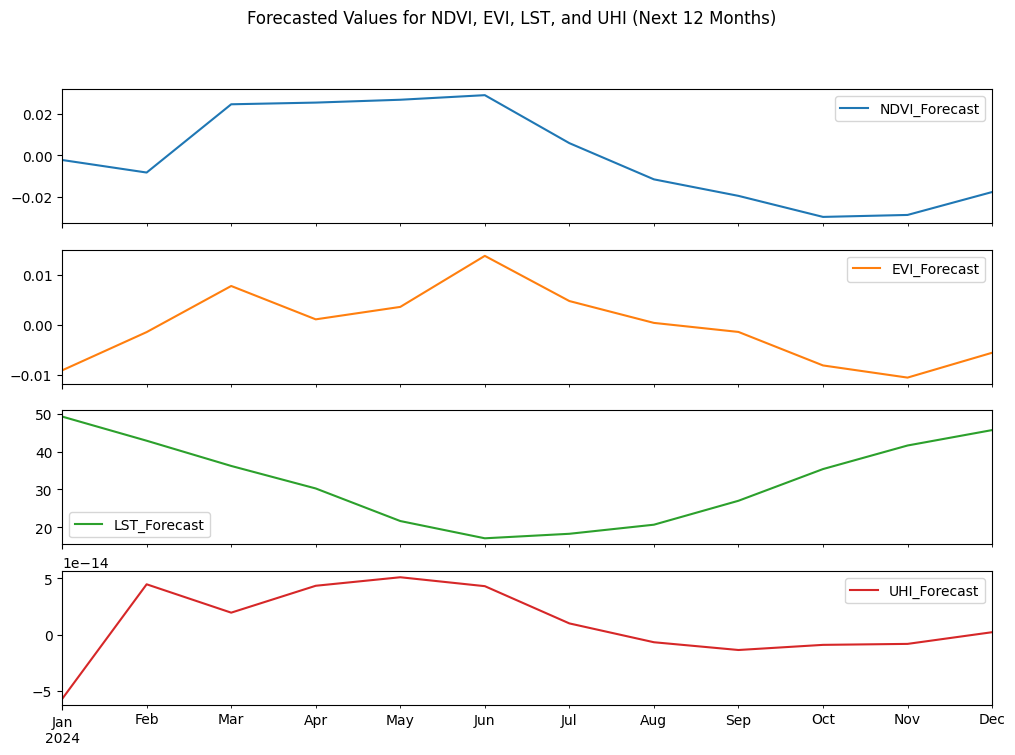


Forecasted values for the next 12 months:
             NDVI_Forecast  EVI_Forecast  LST_Forecast  UHI_Forecast
2024-01-31      -0.002316     -0.009069     49.220633 -5.732661e-14
2024-02-29      -0.008390     -0.001429     42.853371  4.482722e-14
2024-03-31       0.024638      0.007774     36.205504  1.956905e-14
2024-04-30       0.025458      0.001117     30.269988  4.351816e-14
2024-05-31       0.026834      0.003601     21.687286  5.110133e-14
2024-06-30       0.029051      0.013789     17.138473  4.315921e-14
2024-07-31       0.005834      0.004769     18.326593  9.990897e-15
2024-08-31      -0.011685      0.000407     20.721860 -6.783617e-15
2024-09-30      -0.019680     -0.001396     27.029419 -1.369442e-14
2024-10-31      -0.029858     -0.008085     35.382359 -9.119386e-15
2024-11-30      -0.028910     -0.010511     41.592539 -8.247662e-15
2024-12-31      -0.017825     -0.005552     45.655091  2.153718e-15


In [20]:
## The Vector Autoregression (VAR) model output provides insights into how NDVI, EVI, LST, and UHI influence each other over time.
## Creating a forecast of UHI and NDVI

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv(csv_file_path)

df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df.set_index('Date', inplace=True)

# Select relevant columns and drop any rows with NaN values due to lagging or other preprocessing
data = df[['NDVI_Mean', 'EVI_Mean', 'LST_Mean', 'UHI_Mean']].dropna()

# Function to check and difference non-stationary series
def make_stationary(series):
    result = adfuller(series)
    if result[1] > 0.05:  # If p-value > 0.05, difference the series
        return series.diff().dropna()  # Differencing to make it stationary
    return series

# Apply stationarity check and differencing
for col in data.columns:
    data[col] = make_stationary(data[col])

# Drop any remaining NaN values after differencing
data = data.dropna()

# Define the VAR model
model = VAR(data)

# Select optimal lag order
lag_order = model.select_order(maxlags=12)  # Adjust maxlags as needed
print("Selected Lag Order by AIC:", lag_order.aic)

# Fit the model with the selected lag order
var_model = model.fit(lag_order.aic)

# Print model summary
print(var_model.summary())

# Forecasting: Generate forecasts for the next 12 months
forecast_steps = 12
forecast = var_model.forecast(data.values[-lag_order.aic:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(data.index[-1], periods=forecast_steps + 1, freq='M')[1:],
                           columns=['NDVI_Forecast', 'EVI_Forecast', 'LST_Forecast', 'UHI_Forecast'])

# Plot forecasted values
forecast_df.plot(figsize=(12, 8), subplots=True)
plt.suptitle("Forecasted Values for NDVI, EVI, LST, and UHI (Next 12 Months)")
plt.show()

# Print forecasted values
print("\nForecasted values for the next 12 months:\n", forecast_df)

The forecast suggests that vegetation plays a cooling role by reducing LST during certain periods, which helps mitigate UHI effects. The challenge lies in interpreting near-zero UHI values and understanding that the relationship between these indices might be complex and influenced by multiple factors. Policymakers and urban planners could use these insights to promote vegetation strategies for urban cooling and sustainability.

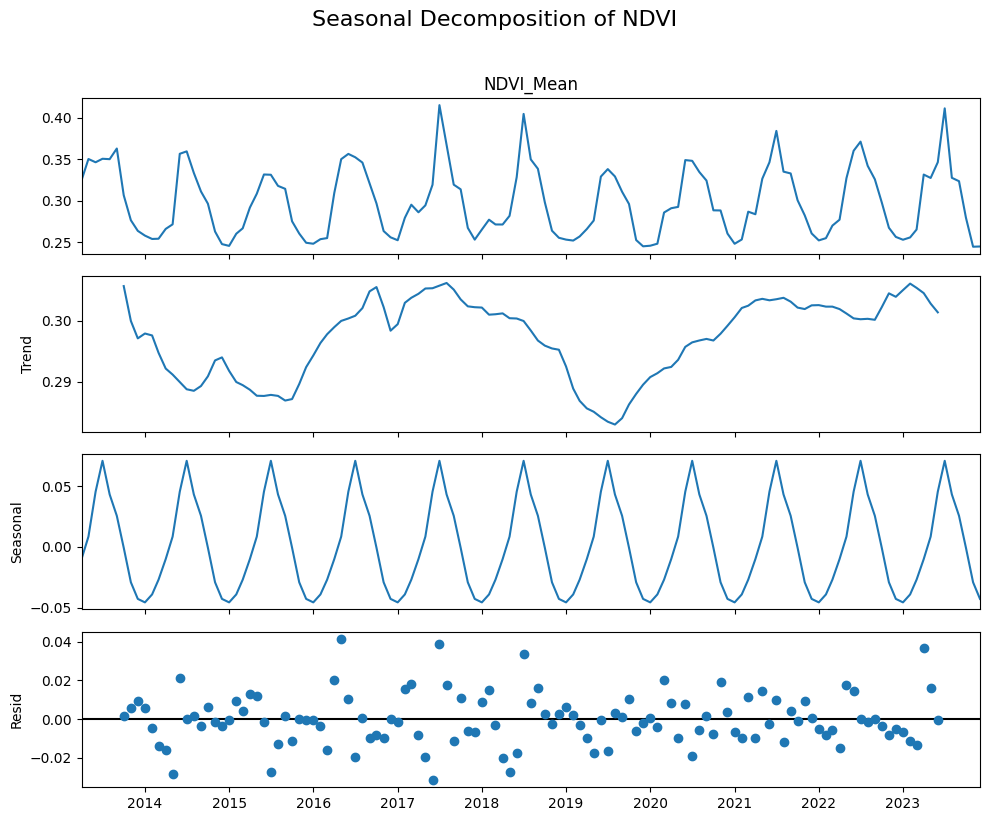

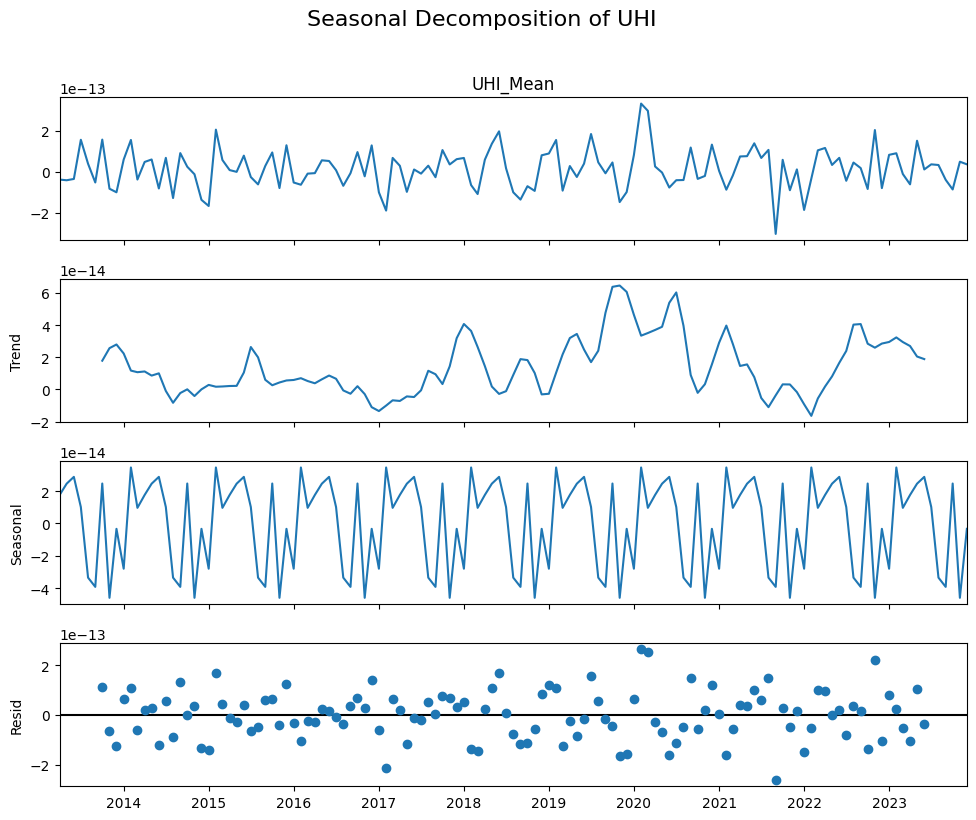

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

monthly_data_df = pd.read_csv(csv_file_path)

# Create a Date column for easier time indexing and set it as the index
monthly_data_df['Date'] = pd.to_datetime(monthly_data_df['Year'].astype(str) + '-' + monthly_data_df['Month'].astype(str) + '-01')
monthly_data_df.set_index('Date', inplace=True)

# seasonal decomposition NDVI
ndvi_decomposition = seasonal_decompose(monthly_data_df['NDVI_Mean'], model='additive', period=12)

# Plot
fig_ndvi = ndvi_decomposition.plot()
fig_ndvi.set_size_inches(10, 8)
plt.suptitle('Seasonal Decomposition of NDVI', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Seasinal Decomposition for UHI
uhi_decomposition = seasonal_decompose(monthly_data_df['UHI_Mean'], model='additive', period=12)

# Plot
fig_uhi = uhi_decomposition.plot()
fig_uhi.set_size_inches(10, 8)
plt.suptitle('Seasonal Decomposition of UHI', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

Based off this decomposition indicates that vegetation’s ability to mitigate UHI might be limited by its seasonal growth pattern, as peak NDVI typically occurs in cooler, wetter months. For effective UHI reduction, we might consider vegetation cooling capacity in warmer months. Additionally, long-term NDVI trends and unexpected declines can inform strategies for enhancing urban vegetation resilience, ensuring that vegetation remains effective in UHI mitigation across different environmental conditions.


In [23]:
# Now to  see if  does the decompisition of summer months compare as summer month has greater LST and a Lower NDVI.

monthly_data_df['Date'] = pd.to_datetime(monthly_data_df['Year'].astype(str) + '-' + monthly_data_df['Month'].astype(str) + '-01')
monthly_data_df.set_index('Date', inplace=True)

#  (December, January, February)
summer_monthly_df = monthly_data_df[monthly_data_df.index.month.isin([12, 1, 2])]

# Display
print(summer_monthly_df.head(15))

            system:index  Year  Month  NDVI_Mean  EVI_Mean  ET (mm/day)  \
Date                                                                      
2013-12-01             8  2013     12   0.263706  0.186462     3.104590   
2014-01-01             9  2014      1   0.257996  0.177995     3.087712   
2014-02-01            10  2014      2   0.253972  0.170409     2.822208   
2014-12-01            20  2014     12   0.247788  0.168920     2.752741   
2015-01-01            21  2015      1   0.245645  0.160320     2.732255   
2015-02-01            22  2015      2   0.260245  0.173718     2.280219   
2015-12-01            32  2015     12   0.249404  0.173873     2.697267   
2016-01-01            33  2016      1   0.248220  0.164385     2.253596   
2016-02-01            34  2016      2   0.253717  0.172866     2.551938   
2016-12-01            44  2016     12   0.255956  0.172117     2.708564   
2017-01-01            45  2017      1   0.252435  0.171363     2.642523   
2017-02-01            46 

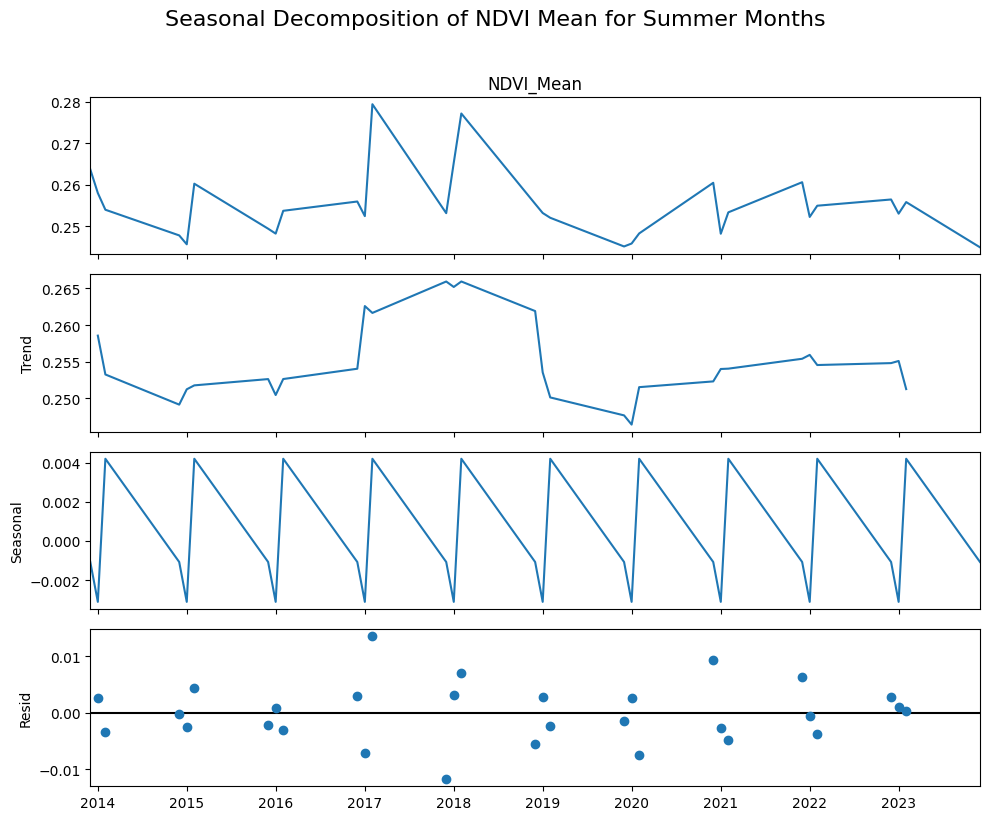

In [24]:
ndvi_summer_monthly_decomposition = seasonal_decompose(summer_monthly_df['NDVI_Mean'], model='additive', period=3)

# Plot the NDVI decomposition for summer months
fig_ndvi_summer_monthly = ndvi_summer_monthly_decomposition.plot()
fig_ndvi_summer_monthly.set_size_inches(10, 8)
plt.suptitle('Seasonal Decomposition of NDVI Mean for Summer Months', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

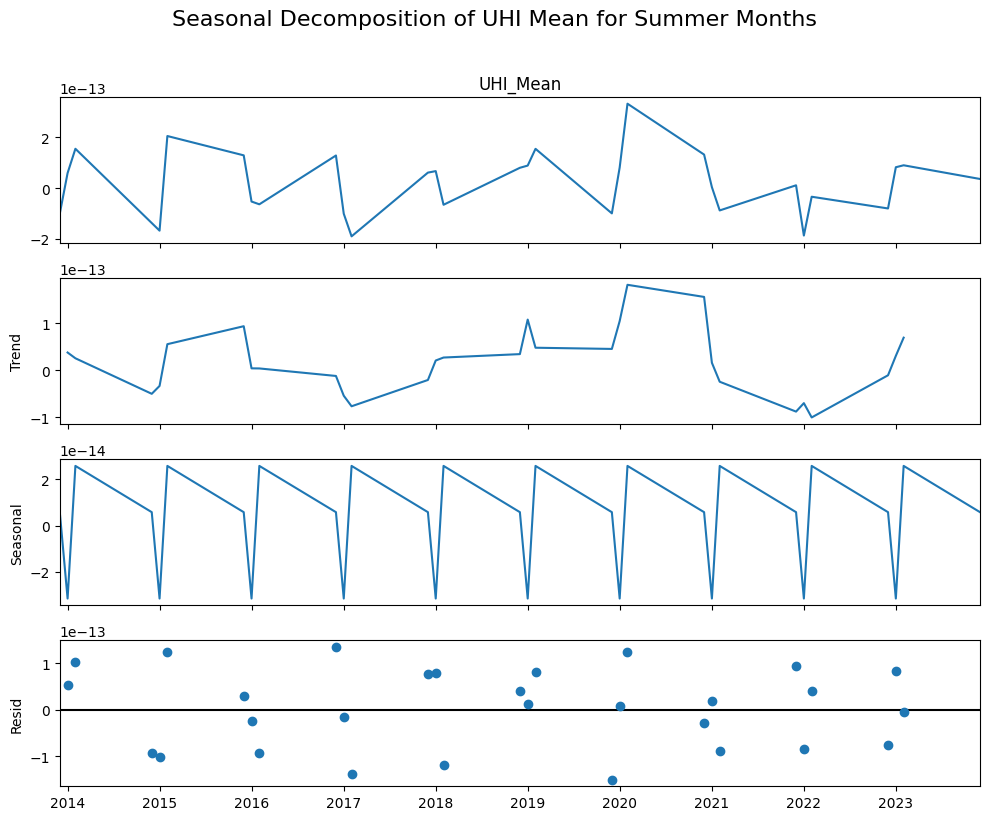

In [25]:
uhi_summer_monthly_decomposition = seasonal_decompose(summer_monthly_df['UHI_Mean'], model='additive', period=3)

# Plot the UHI decomposition for summer months
fig_uhi_summer_monthly = uhi_summer_monthly_decomposition.plot()
fig_uhi_summer_monthly.set_size_inches(10, 8)
plt.suptitle('Seasonal Decomposition of UHI Mean for Summer Months', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

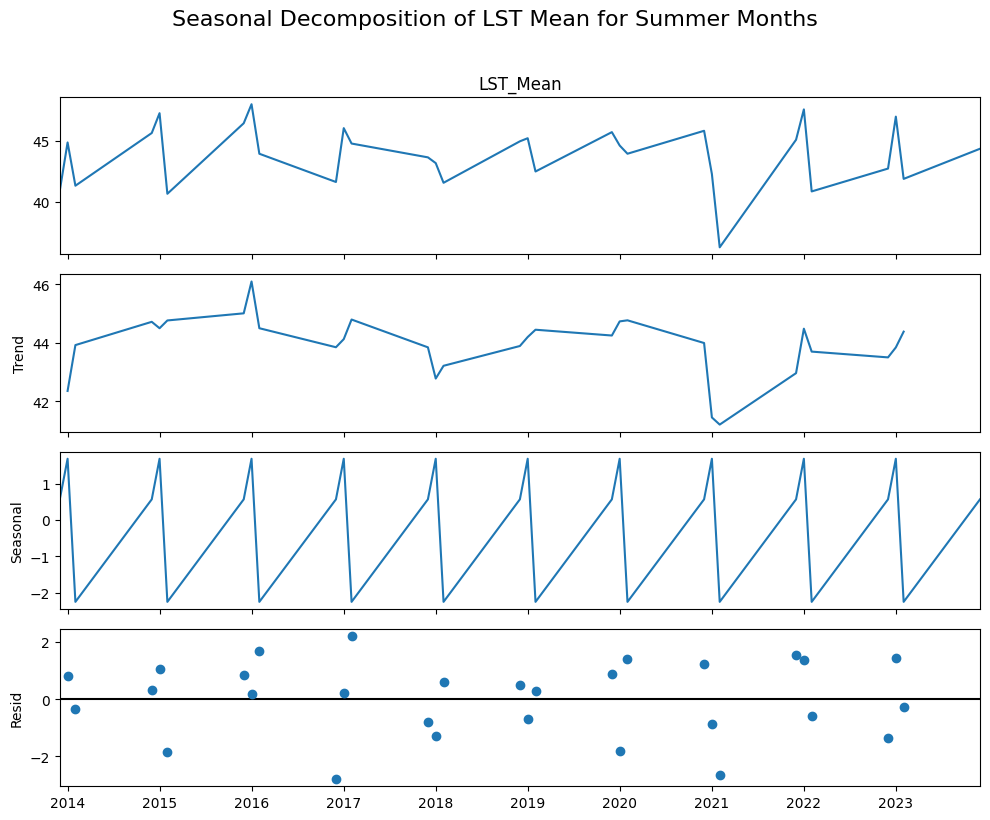

In [26]:
lst_summer_monthly_decomposition = seasonal_decompose(summer_monthly_df['LST_Mean'], model='additive', period=3)

# Plot the  LST decomposition for summer months
fig_lst_summer_monthly = lst_summer_monthly_decomposition.plot()
fig_lst_summer_monthly.set_size_inches(10, 8)
plt.suptitle('Seasonal Decomposition of LST Mean for Summer Months', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

The seasonal component patterns of NDVI and UHI align inversely: as NDVI decreases over the summer months, UHI tends to increase. The inverse relationship in the seasonal component of UHI when compared to NDVI suggests that UHI may intensify as vegetation health and density decline through the summer. However,  UHI is driven by a broader range of factors beyond vegetation. While NDVI influences UHI, other elements such as urban infrastructure, human activity, and local climate conditions play a significant role.

The use of Urban Thermal Field Variance Index (UTFVI) helps us to quantify the impact of UHI on urban settings, with higher UTFVI more intense is the effect of UHI.

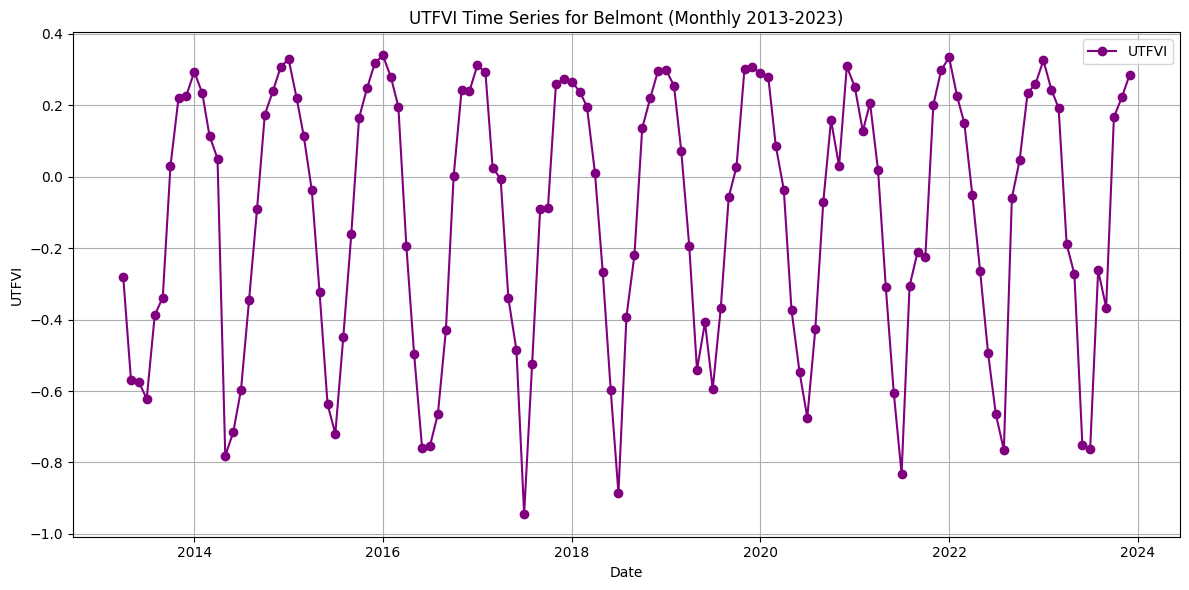

In [52]:
def calculate_utfvi(lst, lst_mean):
    lst = np.where(lst == 0, np.nan, lst)
    utfvi = (lst - lst_mean) / lst
    return utfvi

# Group data by Year and Month, then calculate monthly median LST
df_monthly_lst = df.groupby(['Year', 'Month'])['LST_Mean'].median().reset_index()

# Calculate the mean LST for all data to use as a baseline for UTFVI calculation
lst_mean = df_monthly_lst['LST_Mean'].mean()

# Calculate UTFVI for each monthly median LST value
df_monthly_lst['UTFVI'] = calculate_utfvi(df_monthly_lst['LST_Mean'], lst_mean)

# Convert 'Year' and 'Month' to a datetime format for plotting
df_monthly_lst['Date'] = pd.to_datetime(df_monthly_lst[['Year', 'Month']].assign(DAY=1))

# Plotting the UTFVI for monthly data
plt.figure(figsize=(12, 6))
plt.plot(df_monthly_lst['Date'], df_monthly_lst['UTFVI'], label='UTFVI', color='purple', marker='o')
plt.title('UTFVI Time Series for Belmont (Monthly 2013-2023)')
plt.xlabel('Date')
plt.ylabel('UTFVI')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

keypoints from UTFVI:

1. The value of UTFVI ranges from approximately -0.46 to 0.38 showing us that even in high vegetation areas there are periods where UTFVI indicates some level of thermal discomfort, though the extremes are relatively moderated.

2. The value of the UTFVI is from -1.2 to 0.16 which cover a broader spectrum  significantly lower values in certain months prominently the middle months of the year. It suggests that low vegetation areas are more susceptible to thermal extremes and potentially lower when vegetation are lower.

3. The high NDVI zones represented in peaks in summer reflect the capacity of vegetation to mitigate the heat regarless of increase in UTFVI during high temp.


For Effective visualization of NDVI, LST and UHI:



1. Go to the setting  next to the slider.
2. Get Stretch = 100%
3. Choose colormap: Greens for NVDI, CoolWarm for LST and Inferno for UHI
                  

In [29]:
# Define the Area of Interest (AOI)
aoi = ee.Geometry.Polygon([
    [[115.8980475883435, -31.953507794644967],
     [115.93804468917358, -31.98787496739092],
     [115.94113459395874, -31.984380588412932],
     [115.97838511275756, -31.98743817729756],
     [115.98748316573608, -31.949138164617683],
     [115.95950236129272, -31.92408160792704],
     [115.96156229781616, -31.920147691041528],
     [115.95933069991577, -31.91927346443831],
     [115.95315089034546, -31.92189611932004],
     [115.94954600142944, -31.92408160792704],
     [115.94405283736694, -31.92233322119627],
     [115.94216456222046, -31.921604716915123],
     [115.94044794845092, -31.923790212446843],
     [115.93976130294311, -31.926121350435416],
     [115.9390746574353, -31.92961794661597],
     [115.93581309127319, -31.931220508760497],
     [115.9306632499646, -31.93224030649035],
     [115.92414011764038, -31.932968726514428],
     [115.91950526046264, -31.932823042971346],
     [115.91624369430053, -31.932968726514428],
     [115.91315378951538, -31.934425549247763],
     [115.91023554610717, -31.936465062288214],
     [115.9086905937146, -31.939961265076533],
     [115.91538538741577, -31.943457334871457],
     [115.91727366256225, -31.94418566600504],
     [115.91830363082397, -31.946079299935928],
     [115.91830363082397, -31.948555531577295],
     [115.91555704879272, -31.95103169648125],
     [115.91126551436889, -31.952925189316794],
     [115.90766062545288, -31.953799095923383],
     [115.90268244552124, -31.954818643123048]]
])

# Function to calculate NDVI for a given year
def calculate_ndvi_for_year(year, aoi):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    landsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(aoi)

    # Calculate the median image and NDVI
    median_image = landsat8.median()
    ndvi = median_image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return ndvi

# Calculate NDVI for 2013 and 2023
ndvi_2013 = calculate_ndvi_for_year(2013, aoi)
ndvi_2023 = calculate_ndvi_for_year(2023, aoi)

# Visualization parameters for NDVI
ndvi_vis_params = {
    'min': -0.34,
    'max': 0.49,
    'palette': ['grey', 'white', 'green']  # low to high NDVI
}

# Create a map
Map = geemap.Map(basemap='HYBRID')
Map.centerObject(aoi, 12)
Map.addLayer(aoi, {'color': 'gray'}, 'AOI')
Map.addLayer(ndvi_2013.clip(aoi), ndvi_vis_params, 'NDVI 2013')
Map.addLayer(ndvi_2023.clip(aoi), ndvi_vis_params, 'NDVI 2023')

# Calculate the difference between NDVI for 2023 and 2013
ndvi_difference = ndvi_2023.subtract(ndvi_2013).rename('NDVI Difference')
ndvi_diff_vis_params = {
    'min': -0.2,
    'max': 0.2,
    'palette': ['red', 'white', 'green']  # Red for decrease, green for increase
}

# Add NDVI difference layer to the map
Map.addLayer(ndvi_difference.clip(aoi), ndvi_diff_vis_params, 'NDVI Difference (2023 - 2013)')

# Display the map
Map


Map(center=[-31.95614508410954, 115.94863010303058], controls=(WidgetControl(options=['position', 'transparent…

In [30]:
# Calculate the difference between NDVI for 2023 and 2013
ndvi_difference = ndvi_2023.subtract(ndvi_2013).rename('NDVI_Difference')

# Calculate statistics for the NDVI difference
ndvi_diff_stats = ndvi_difference.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), sharedInputs=True).combine(ee.Reducer.stdDev(), sharedInputs=True),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
)

# Get the statistics as a dictionary
ndvi_diff_stats_dict = ndvi_diff_stats.getInfo()

# Print the dictionary to verify the keys
print('NDVI Difference Statistics:', ndvi_diff_stats_dict)

# Access and print the correct keys based on the output
print('Minimum NDVI Difference:', ndvi_diff_stats_dict.get('NDVI_Difference_min', 'Key not found'))
print('Maximum NDVI Difference:', ndvi_diff_stats_dict.get('NDVI_Difference_max', 'Key not found'))
print('Mean NDVI Difference:', ndvi_diff_stats_dict.get('NDVI_Difference_mean', 'Key not found'))
print('Standard Deviation of NDVI Difference:', ndvi_diff_stats_dict.get('NDVI_Difference_stdDev', 'Key not found'))


NDVI Difference Statistics: {'NDVI_Difference_max': 0.2914631464276034, 'NDVI_Difference_mean': -0.018382338711370214, 'NDVI_Difference_min': -0.3337243749495889, 'NDVI_Difference_stdDev': 0.04086586152857246}
Minimum NDVI Difference: -0.3337243749495889
Maximum NDVI Difference: 0.2914631464276034
Mean NDVI Difference: -0.018382338711370214
Standard Deviation of NDVI Difference: 0.04086586152857246


In [31]:
# Function to calculate LST for a given year
def calculate_lst_for_year(year, aoi):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    landsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(aoi)

    # Calculate the median image and extract LST band (SR_B10)
    median_image = landsat8.median()

    # Convert the thermal band from digital number (DN) to brightness temperature (in Kelvin)
    lst = median_image.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15).rename('LST_Celsius')


    return lst

# Calculate LST for 2013 and 2023
lst_2013 = calculate_lst_for_year(2013, aoi)
lst_2023 = calculate_lst_for_year(2023, aoi)

# Visualization parameters for LST
lst_vis_params = {
    'min': 16.29,
    'max': 47.97,
    'palette': [
        '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
        '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
        '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
        'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
        'ff0000', 'de0101', 'c21301', 'a71001', '911003'
    ]
}

# Create a map and add LST layers
Map = geemap.Map(basemap='HYBRID')
Map.centerObject(aoi, 12)
Map.addLayer(aoi, {'color': 'gray'}, 'AOI')
Map.addLayer(lst_2013.clip(aoi), lst_vis_params, 'LST 2013')
Map.addLayer(lst_2023.clip(aoi), lst_vis_params, 'LST 2023')

# Calculate the difference between LST for 2023 and 2013
lst_difference = lst_2023.subtract(lst_2013).rename('LST Difference')
lst_diff_vis_params = {
    'min': -10,
    'max': 10,
    'palette': ['blue', 'white', 'red']  # Blue for decrease, red for increase
}

# Add LST difference layer to the map
Map.addLayer(lst_difference.clip(aoi), lst_diff_vis_params, 'LST Difference (2023 - 2013)')

# Display the map
Map


Map(center=[-31.95614508410954, 115.94863010303058], controls=(WidgetControl(options=['position', 'transparent…

In [32]:
# Function to calculate normalized UHI for a given year
def calculate_normalized_uhi_for_year(year, aoi):
    lst_image = calculate_lst_for_year(year, aoi)

    # Calculate mean LST within the AOI
    lst_mean = lst_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).values().get(0)

    # Calculate standard deviation of LST within the AOI
    lst_std = lst_image.reduceRegion(
        reducer=ee.Reducer.stdDev(),
        geometry=aoi,
        scale=30,
        maxPixels=1e9
    ).values().get(0)

    # Convert mean and stdDev to ee.Number
    lst_mean = ee.Number(lst_mean)
    lst_std = ee.Number(lst_std)

    # Print mean and standard deviation
    print(f'Mean LST in AOI for {year}:', lst_mean.getInfo())
    print(f'STD LST in AOI for {year}:', lst_std.getInfo())

    # Calculate normalized UHI
    uhi = lst_image.subtract(lst_mean).divide(lst_std).rename(f'UHI_{year}')
    return uhi

# Calculate UHI for 2013 and 2023
uhi_2013 = calculate_normalized_uhi_for_year(2013, aoi)
uhi_2023 = calculate_normalized_uhi_for_year(2023, aoi)

# Calculate the difference between UHI for 2023 and 2013
uhi_difference = uhi_2023.subtract(uhi_2013).rename('UHI_Difference')

# Visualization parameters for UHI
uhi_vis_params = {
    'min': -4,
    'max': 4,
    'palette': [
        '313695', '74add1', 'fed976', 'feb24c', 'fd8d3c', 'fc4e2a', 'e31a1c', 'b10026'
    ]
}

uhi_diff_vis_params = {
    'min': -2,
    'max': 2,
    'palette': ['purple', 'white', 'orange']  # Purple for decrease, orange for increase
}

# Create a map and add UHI layers
Map = geemap.Map(basemap='HYBRID')
Map.centerObject(aoi, 12)
Map.addLayer(aoi, {'color': 'gray'}, 'AOI')
Map.addLayer(uhi_2013.clip(aoi), uhi_vis_params, 'Normalized UHI 2013')
Map.addLayer(uhi_2023.clip(aoi), uhi_vis_params, 'Normalized UHI 2023')
Map.addLayer(uhi_difference.clip(aoi), uhi_diff_vis_params, 'UHI Difference (2023 - 2013)')

# Display the map
Map


Mean LST in AOI for 2013: 19.342832530604845
STD LST in AOI for 2013: 1.570348117581435
Mean LST in AOI for 2023: 19.21649549111214
STD LST in AOI for 2023: 1.5272707740269267


Map(center=[-31.95614508410954, 115.94863010303058], controls=(WidgetControl(options=['position', 'transparent…

UHI Difference Statistics: {'UHI_Difference_max': 7.744530486397104, 'UHI_Difference_mean': 6.967135856536806e-14, 'UHI_Difference_min': -4.832959696332033, 'UHI_Difference_stdDev': 0.9119700352807747}
Minimum UHI Difference: -4.832959696332033
Maximum UHI Difference: 7.744530486397104
Mean UHI Difference: 6.967135856536806e-14
Standard Deviation of UHI Difference: 0.9119700352807747


In [33]:
# UTFVI >>>


# Function to calculate LST for a given year with cloud masking
def calculate_lst_for_year(year, aoi):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    landsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start_date, end_date) \
        .filterBounds(aoi)


    # Apply scale factors
    def apply_scale_factors(image):
        thermal_bands = image.select('ST_B10').multiply(0.00341802).add(149.0)
        return image.addBands(thermal_bands, overwrite=True)

    # Calculate median image and LST
    median_image = landsat8.map(apply_scale_factors).median()
    lst = median_image.select('ST_B10').rename('LST')
    return lst

# Calculate LST for 2013 and 2023
lst_2013 = calculate_lst_for_year(2013, aoi)
lst_2023 = calculate_lst_for_year(2023, aoi)

# Calculate mean LST within the AOI for normalization
lst_mean_2013 = lst_2013.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('LST')

lst_mean_2023 = lst_2023.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('LST')

# Calculate UTFVI for 2013 and 2023 using the formula
utfvi_2013 = lst_2013.subtract(ee.Number(lst_mean_2013)).divide(lst_2013).rename('UTFVI_2013')
utfvi_2023 = lst_2023.subtract(ee.Number(lst_mean_2023)).divide(lst_2023).rename('UTFVI_2023')

# Calculate the difference between UTFVI for 2023 and 2013
utfvi_difference = utfvi_2023.subtract(utfvi_2013).rename('UTFVI_Difference')

# Visualization parameters for UTFVI 2013 and 2023
utfvi_vis_params_2013 = {
    'min': -0.07240009655288211,
    'max': 0.015391825499629181,
    'palette': ['313695', '74add1', 'fed976', 'feb24c', 'fd8d3c', 'fc4e2a', 'e31a1c', 'b10026']
}

utfvi_vis_params_2023 = {
    'min': -0.5,
    'max': 0.2,
    'palette': ['313695', '74add1', 'fed976', 'feb24c', 'fd8d3c', 'fc4e2a', 'e31a1c', 'b10026']
}

utfvi_diff_vis_params = {
    'min': -0.2,
    'max': 0.2,
    'palette': ['purple', 'white', 'orange']  # Purple for decrease, orange for increase
}

# Create a map
Map = geemap.Map(basemap='HYBRID')
Map.centerObject(aoi, 12)
Map.addLayer(aoi, {'color': 'gray'}, 'AOI')

# Add UTFVI layers for 2013, 2023, and their difference
Map.addLayer(utfvi_2013.clip(aoi), utfvi_vis_params_2013, 'UTFVI 2013')
Map.addLayer(utfvi_2023.clip(aoi), utfvi_vis_params_2023, 'UTFVI 2023')
Map.addLayer(utfvi_difference.clip(aoi), utfvi_diff_vis_params, 'UTFVI Difference (2023 - 2013)')

# Display the map
Map


Map(center=[-31.95614508410954, 115.94863010303058], controls=(WidgetControl(options=['position', 'transparent…